In [1]:

import os, sys, math, json
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append('/home/spina/Desktop/units/DL/project/mice-representation/src')

from pipeline.mouse_transforms import mouse_transform

from pipeline.transforms import UnNormalize
from pipeline.mouse_csf import load_or_fit_params
from pipeline.plot_utils import *

# IMAGE_PATH = '/home/spina/Desktop/units/DL/project/mice-representation/assets/ant.png'  
IMAGE_PATH = '/home/spina/Desktop/units/DL/project/mice-representation/assets/dog.JPEG'  
CSF_JSON = '/home/spina/Desktop/units/DL/project/mice-representation/cache/mouse_csf_params28.json'
os.makedirs(os.path.dirname(CSF_JSON), exist_ok=True)


np.random.seed(0)
torch.manual_seed(0)

CSF_FIT = True

IMG_SIZE = 224

In [2]:
blur_sig, blur_ker, noise_std = load_or_fit_params(CSF_JSON, force_fit=CSF_FIT, pca_n = 16)
print(f'CSF params :blur_sigma={blur_sig:.3f}, blur_ker={blur_ker}, noise_std={noise_std:.3f}')

Fitting CSF params (this may take a while)...
Starting parallel fitting on 1 processes for 900 combinations...


Fitting CSF Params: 100%|██████████| 900/900 [44:40<00:00,  2.98s/it]  


Saved detailed grid search log to /home/spina/Desktop/units/DL/project/mice-representation/cache/mouse_csf_params28_grid_log.json

Best result: Patch=32, Sigma=1.95, Kernel=29, Noise=0.214, Total Error=0.5900


Refine L2: 100%|██████████| 49/49 [03:03<00:00,  3.75s/it]

After refinement: Patch=32, Sigma=1.950, Kernel=29, Noise=0.214, Total Error=0.5900
CSF params :blur_sigma=1.950, blur_ker=29, noise_std=0.214


In [3]:
noise_rng = torch.Generator().manual_seed(1)# Generators keep motion and noise reproducible
affine_rng = torch.Generator().manual_seed(2)

tfm = mouse_transform(
    img_size=224,
    img_scale_fact=1,
    roll_deg=0.0,
    translate=(0, 0),
    blur_sig=blur_sig,
    blur_ker=blur_ker,
    noise_std=noise_std,
    normalize='imagenet',
    apply_motion=False, # was True
    apply_csf=True,
    apply_warp=False,
    noise_rng=noise_rng,
    affine_rng=affine_rng,
    to_gray=True,
    gray_keep_channels=True,
    to_mouse=False,
    resize=False,
)

unnorm = UnNormalize('imagenet')

In [4]:
assert os.path.isfile(IMAGE_PATH), f'Image not found: {IMAGE_PATH}'
img_pil = Image.open(IMAGE_PATH).convert('RGB')

out = tfm(img_pil)

# The pipeline returns a dict after the affine step; extract the tensor
if isinstance(out, dict):
    img_t = out['imgs']
    affine_params = out.get('affine', None)  # (angle, translations, scale, shear)
else:
    img_t = out
    affine_params = None
disp = unnorm(out if isinstance(out, dict) else img_t)
disp_t = disp['imgs'] if isinstance(disp, dict) else disp
disp_t = disp_t.detach().cpu().clamp(0, 1)
disp_t = disp_t[0] if disp_t.dim() == 4 else disp_t
disp_np = disp_t.permute(1, 2, 0).numpy()

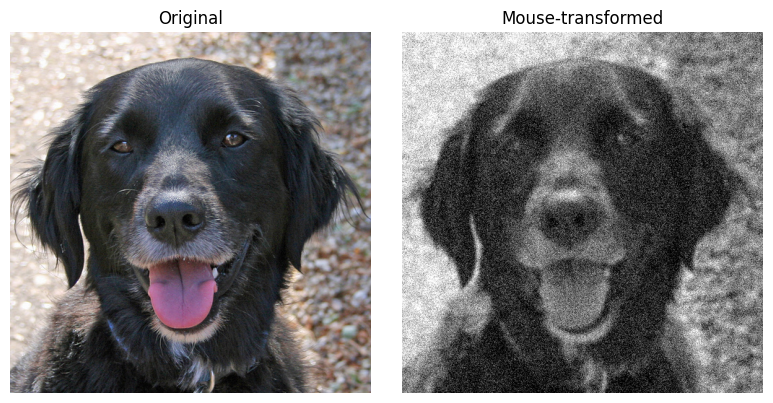

In [5]:
from pipeline.plot_utils import plot_image_pair, print_affine_params

plot_image_pair(img_pil, disp_np, title_left='Original', title_right='Mouse-transformed')
print_affine_params(affine_params)

In [6]:
# Cell — Imports for CSF plotting
import numpy as np
import matplotlib.pyplot as plt

from pipeline.mouse_params import MOUSE_CSF_TARGET, CONTRAST_SWEEP, THRESH_CRITERION, PATCH_SIZE
from pipeline.mouse_csf import _simulate_detection, _estimate_threshold
import pipeline.mouse_csf as mouse_csf  

mouse_csf.N_SAMPLES_PER_CLASS = 5000  


SIM_IMG_SIZE = 224
mouse_csf.PATCH_SIZE = 28

size = (SIM_IMG_SIZE, SIM_IMG_SIZE)

SF_LIST = sorted(MOUSE_CSF_TARGET.keys())
curves = {}         # sf -> (contrasts, acc)
thresholds = {}     # sf -> threshold

for sf in SF_LIST:
    contrasts, acc = _simulate_detection(size, sf,blur_sig,blur_ker, noise_std , CONTRAST_SWEEP)#
    thr = _estimate_threshold(contrasts, acc, THRESH_CRITERION)
    curves[sf] = (contrasts, acc)
    thresholds[sf] = thr

print('Done. Computed psychometric curves and thresholds for', len(SF_LIST), 'spatial frequencies.')

Done. Computed psychometric curves and thresholds for 6 spatial frequencies.


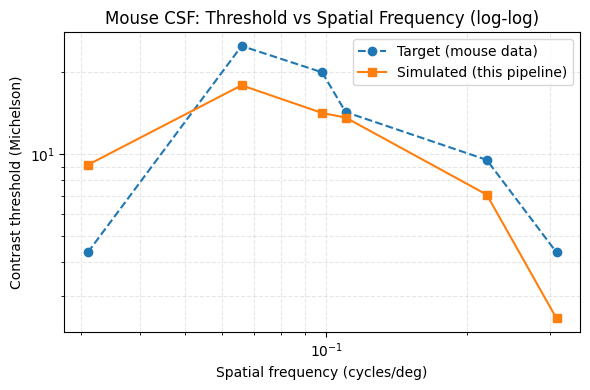

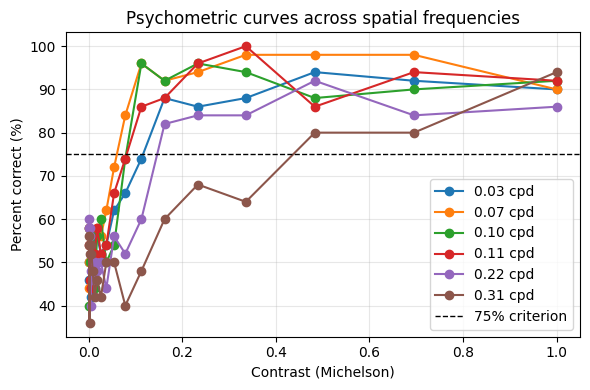

In [7]:
from pipeline.plot_utils import plot_csf_thresholds, plot_psychometric_curves
    
plot_csf_thresholds(SF_LIST, thresholds, MOUSE_CSF_TARGET)

# Psychometric curves
SFS_TO_PLOT = list(curves.keys())
plot_psychometric_curves(curves, SFS_TO_PLOT, threshold_criterion=THRESH_CRITERION)

Saved facet heatmaps to /home/spina/Desktop/units/DL/project/mice-representation/cache/mouse_csf_params28_grid_log_facet_total.png


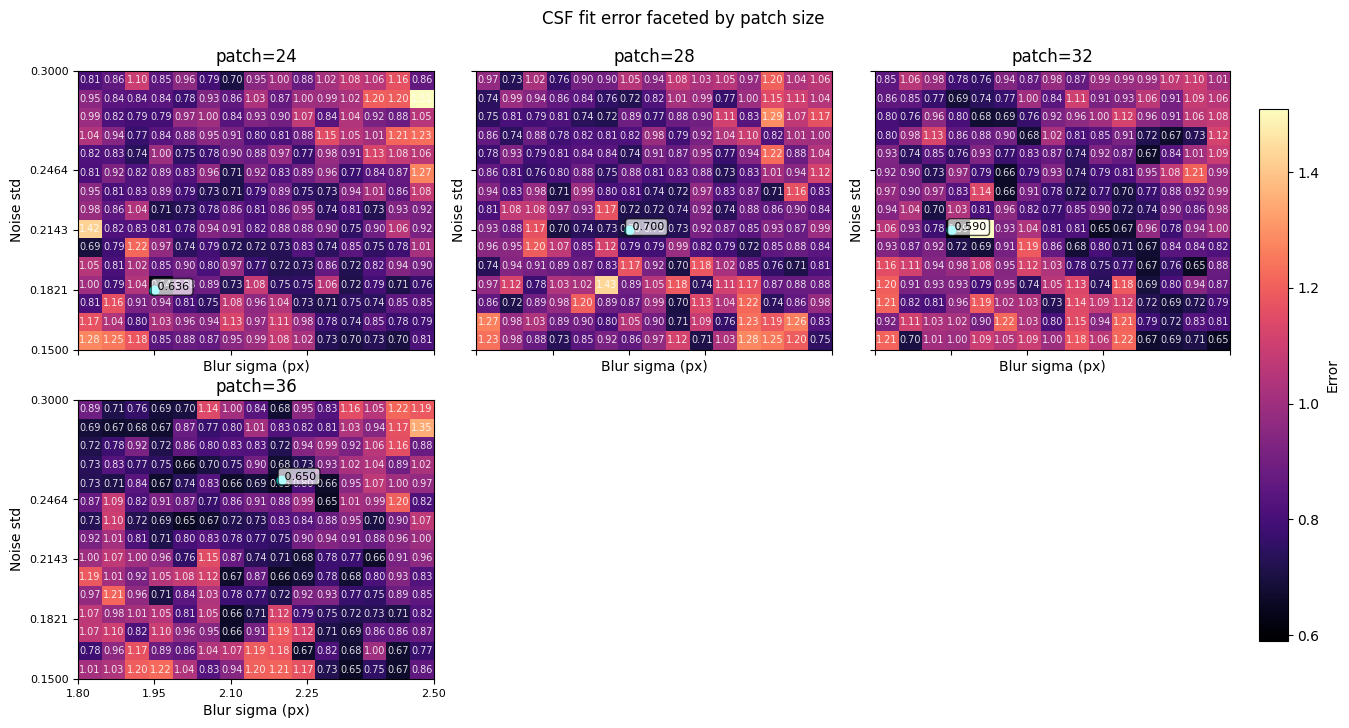

(array([[<Axes: title={'center': 'patch=24'}, xlabel='Blur sigma (px)', ylabel='Noise std'>,
         <Axes: title={'center': 'patch=28'}, xlabel='Blur sigma (px)', ylabel='Noise std'>,
         <Axes: title={'center': 'patch=32'}, xlabel='Blur sigma (px)', ylabel='Noise std'>],
        [<Axes: title={'center': 'patch=36'}, xlabel='Blur sigma (px)', ylabel='Noise std'>,
         <Axes: >, <Axes: >]], dtype=object),
 None)

In [8]:
plot_csf_grid_log("/home/spina/Desktop/units/DL/project/mice-representation/cache/mouse_csf_params28_grid_log.json", 
                  metric="total_error",
                  plot_mode="facet",
                  facet_cols=3,
                  annotate_values=True)

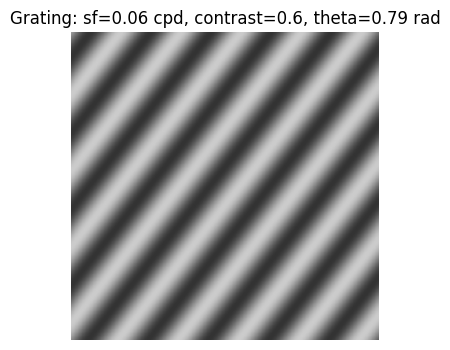

In [9]:
# Example grating using _make_grating
import sys, math
import torch
import matplotlib.pyplot as plt

# Ensure project src is importable
sys.path.append('/home/gamerio/Documents/dl/mice-representation/src')

from pipeline.mouse_csf import _make_grating  # private helper used by CSF code

# Parameters
img_size = 224

sf_cpd   = 0.06
     # spatial frequency (cycles/deg), e.g., 0.06, 0.16, 0.33
contrast = 0.6      # Michelson contrast in [0,1]
phase    = 0.0      # radians
theta    = math.pi/4  # orientation in radians (e.g., 0, pi/4, pi/2)

# Generate and display
g = _make_grating((img_size, img_size), sf_cpd, contrast, phase, theta)  # HxW tensor in [0,1]
from pipeline.plot_utils import plot_grating
plot_grating(g, title=f'Grating: sf={sf_cpd} cpd, contrast={contrast}, theta={theta:.2f} rad')